# ECE 447: Full State Feedback Control of Magnetic Levitation Device

Eric Klavins

Copyright &copy; University of Washington, 2019

# Code

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation

# Uncomment on Google colab
# !pip install JSAnimation
# !pip install control

from JSAnimation.IPython_display import display_animation
from control import * 

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)

# Modeling

In this section we will:

- Encode the model in `sympy`
- Change to error coordinates, so the equilibrium of the system is at $(0,0,0)$.
- Linearize the system

In [2]:
# Model
var("x v i C g L R M u")

params = [
    (R,30.0),
    (L,1.0),
    (C,0.0004),
    (g,9.81),
    (M,0.0012)
]

dotx = v
dotv = (C/M)*(i/x)**2 - g
doti = (1/L)*(-R*i + 2*C*i*v/(x**2) + u)

dotx, dotv, doti

⎛             2⋅C⋅i⋅v          ⎞
⎜             ─────── - R⋅i + u⎟
⎜      2          2            ⎟
⎜   C⋅i          x             ⎟
⎜v, ──── - g, ─────────────────⎟
⎜      2              L        ⎟
⎝   M⋅x                        ⎠

In [3]:
# open loop voltage needed to achieve an x = 5 cm setpoint 
xdes = 5/100
sol = solve([dotx, dotv.subs(x,xdes), doti.subs(x,xdes)], u,i,v)
sol
udes = sol[1][0]
ides = sol[1][1]
udes, ides

⎛           _____           _____⎞
⎜          ╱ M⋅g           ╱ M⋅g ⎟
⎜0.05⋅R⋅  ╱  ─── , 0.05⋅  ╱  ─── ⎟
⎝       ╲╱    C         ╲╱    C  ⎠

In [4]:
# Model in error coordinates
var("xe, ve, ie, ue")

coordsub = [
    (x,xe+xdes),
    (v,ve+0),
    (i,ie+ides),
    (u,ue+udes)
]

dotxe = ve
dotve = dotv.subs(coordsub)
dotie = doti.subs(coordsub)

dotxe, dotve, dotie

⎛                                         ⎛              _____⎞               
⎜                                         ⎜             ╱ M⋅g ⎟               
⎜                           2      2⋅C⋅ve⋅⎜ie + 0.05⋅  ╱  ─── ⎟              _
⎜      ⎛              _____⎞              ⎝          ╲╱    C  ⎠             ╱ 
⎜      ⎜             ╱ M⋅g ⎟       ──────────────────────────── + 0.05⋅R⋅  ╱  
⎜    C⋅⎜ie + 0.05⋅  ╱  ─── ⎟                          2                  ╲╱   
⎜      ⎝          ╲╱    C  ⎠               (xe + 0.05)                        
⎜ve, ──────────────────────── - g, ───────────────────────────────────────────
⎜                      2                                                 L    
⎝         M⋅(xe + 0.05)                                                       

                                   ⎞
                                   ⎟
____     ⎛              _____⎞     ⎟
M⋅g      ⎜             ╱ M⋅g ⎟     ⎟
───  - R⋅⎜ie + 0.05⋅  ╱  ─── ⎟ + ue⎟
 C       ⎝          ╲╱  

In [5]:
# Linearization

steady_state = [ (xe,0), (ve,0), (ie,0)]
f = Matrix([dotxe, dotve, dotie])

A = f.jacobian([xe, ve, ie]).subs(steady_state)
B = f.jacobian([ue]).subs(steady_state)
Cc = Matrix([[1,0,0]])
A,B,Cc

⎛⎡   0            1                 0        ⎤, ⎡0⎤, [1  0  0]⎞
⎜⎢                                           ⎥  ⎢ ⎥           ⎟
⎜⎢                                      _____⎥  ⎢0⎥           ⎟
⎜⎢                                     ╱ M⋅g ⎥  ⎢ ⎥           ⎟
⎜⎢                           40.0⋅C⋅  ╱  ─── ⎥  ⎢1⎥           ⎟
⎜⎢                                  ╲╱    C  ⎥  ⎢─⎥           ⎟
⎜⎢-40.0⋅g         0          ────────────────⎥  ⎣L⎦           ⎟
⎜⎢                                  M        ⎥                ⎟
⎜⎢                                           ⎥                ⎟
⎜⎢                    _____                  ⎥                ⎟
⎜⎢                   ╱ M⋅g                   ⎥                ⎟
⎜⎢         40.0⋅C⋅  ╱  ───                   ⎥                ⎟
⎜⎢                ╲╱    C          -R        ⎥                ⎟
⎜⎢   0     ────────────────        ───       ⎥                ⎟
⎝⎣                L                 L        ⎦                ⎠

# Control Design

In [6]:
# Create numeric matrices from symbolic ones
An = np.array(A.subs(params)).astype(np.float64)
Bn = np.array(B.subs(params)).astype(np.float64)

# Design FSF gains
Kboring = place(An,Bn,[-20,-10+1j,-10-1j])
Kfun = place(An,Bn,[-20,-2+10*1j,-2-10*1j])
Kboring, Kfun

(array([[-189.07113203,    1.58819751,   10.        ]]),
 array([[-101.4425518 ,   -2.79433751,   -6.        ]]))

# Nonlinear Simulation

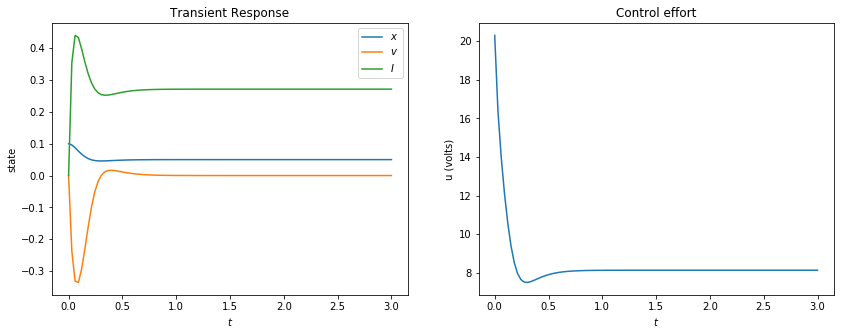

In [9]:
# Simulate the system
ldx = lambdify([x,v,i], dotx.subs(params))
ldv = lambdify([x,v,i], dotv.subs(params))
ldi = lambdify([x,v,i,u], doti.subs(params))

# Steay state values
xss = xdes
vss = 0
iss = ides.subs(params)

# Initial condition as though you trop the ball in from above
X0 = [xss+0.05,0,0]

# Feedforward Input
uff = udes.subs(params)

# Control law
def voltage(x,v,i):
    K = Kboring
    xe = xdes - x          # position error
    ve = vss  - v          # velocity error
    ie = iss  - i          # current error
    return uff + K[0,0]*xe + K[0,1]*ve + K[0,2]*ie

# ODE right hand side
def f(X,t):
    x,v,i = X
    u = voltage(x,v,i)
    return [
        ldx(x,v,i),
        ldv(x,v,i),
        ldi(x,v,i,u),
    ]

# Simulate
tvals = np.linspace(0,3,100)
X = spi.odeint(f,X0,tvals)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plots = ax[0].plot(tvals,X);
ax[1].plot(tvals,voltage(X[:,0],X[:,1],X[:,2]));
fig.subplots_adjust(wspace=0.2)
ax[0].legend(plots, ["$x$", "$v$", "$I$"]);
ax[0].set_xlabel("$t$")
ax[0].set_ylabel("state")
ax[0].set_title("Transient Response");
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("u (volts)")
ax[1].set_title("Control effort");


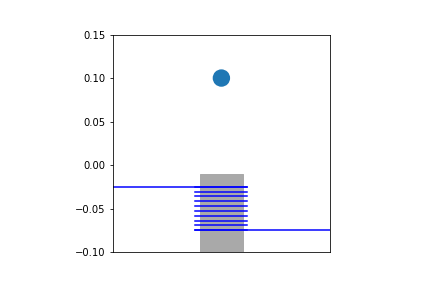
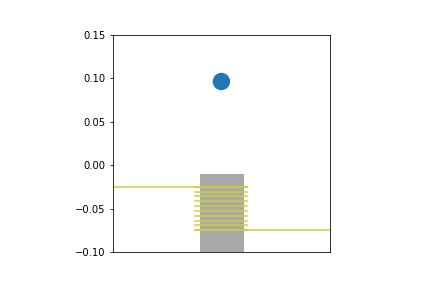
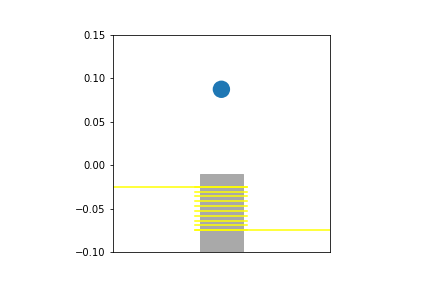
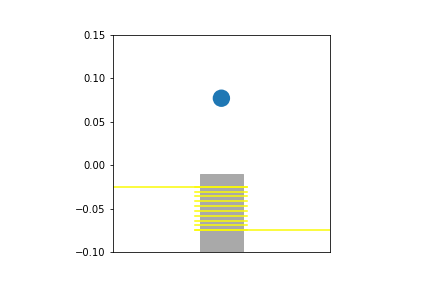
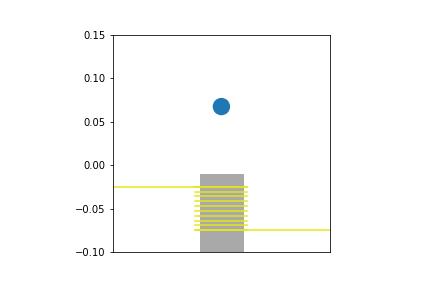
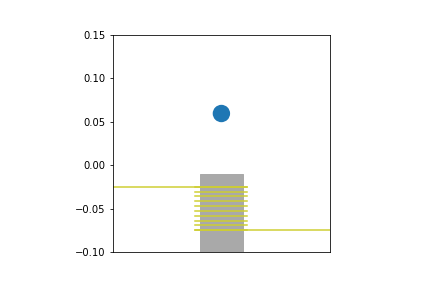
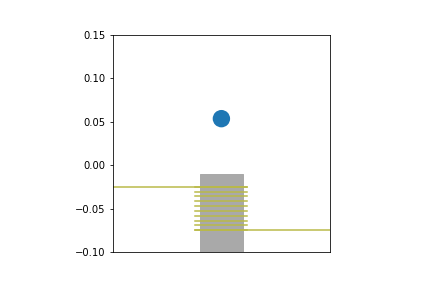
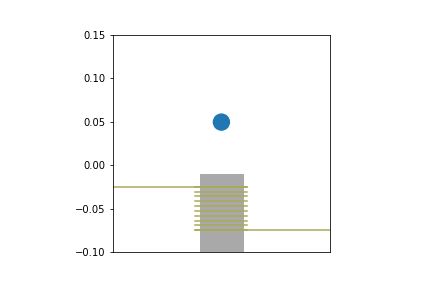
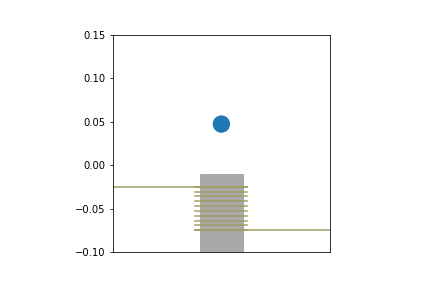
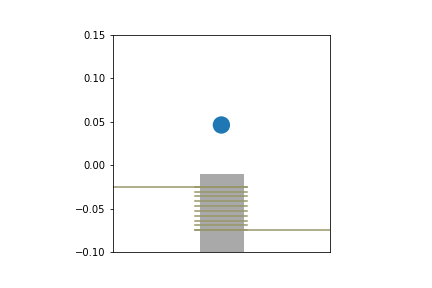
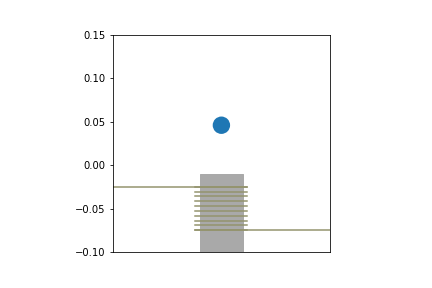
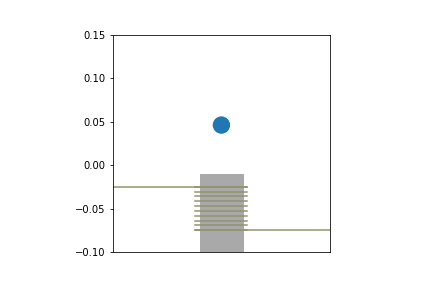
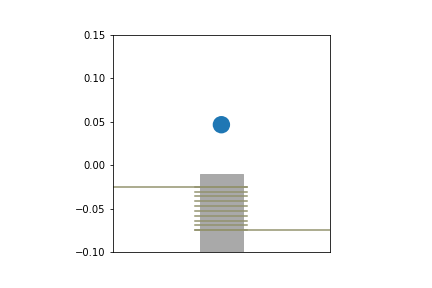
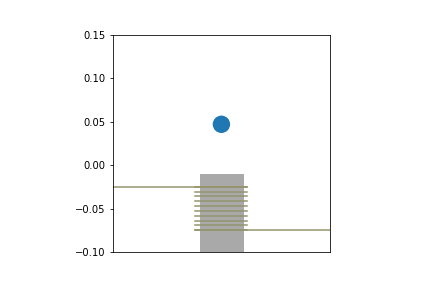
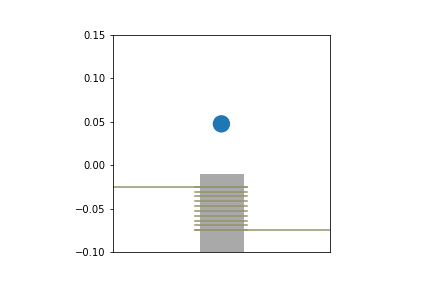
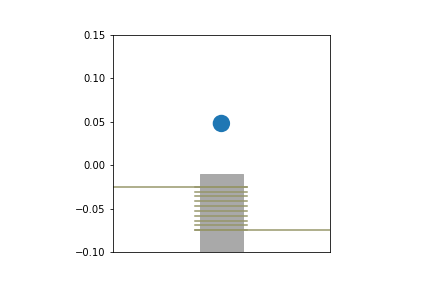
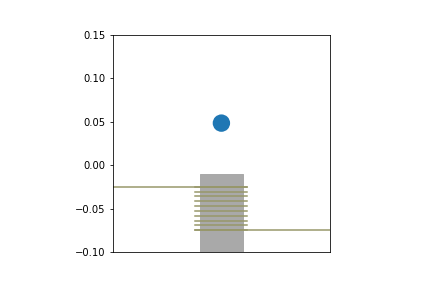
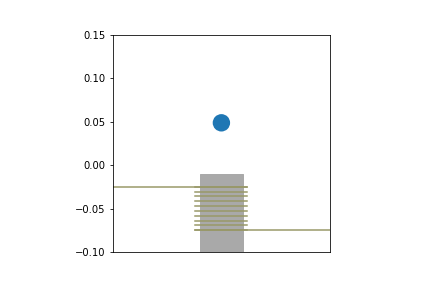
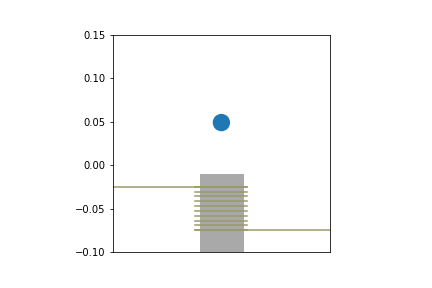
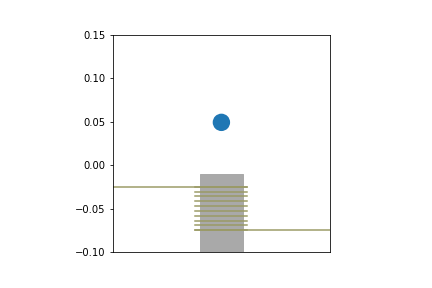
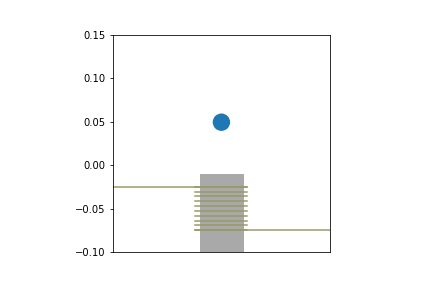
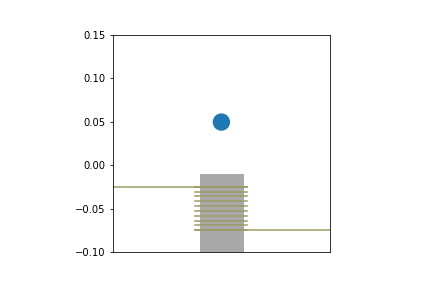
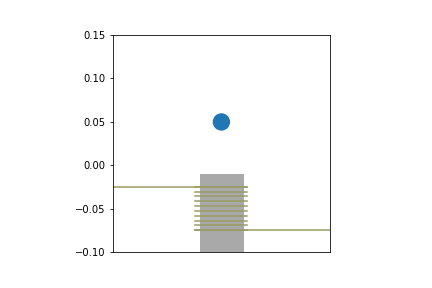
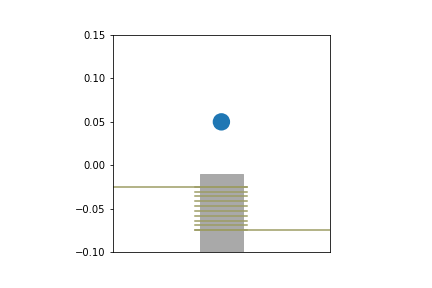
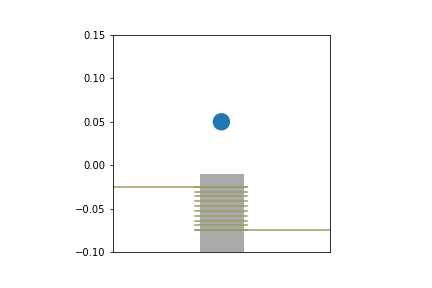
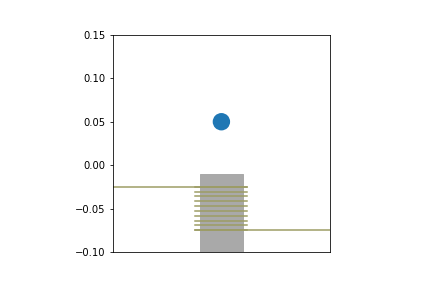
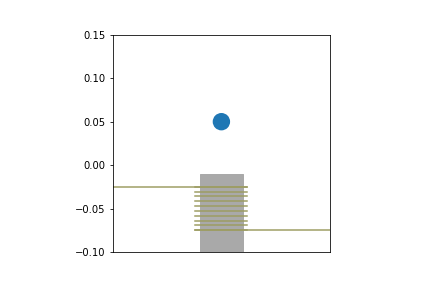
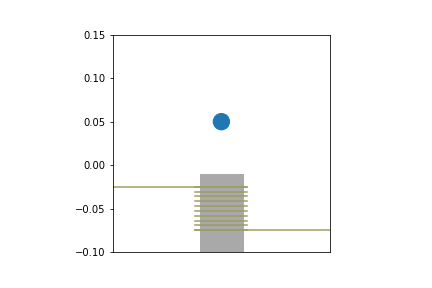
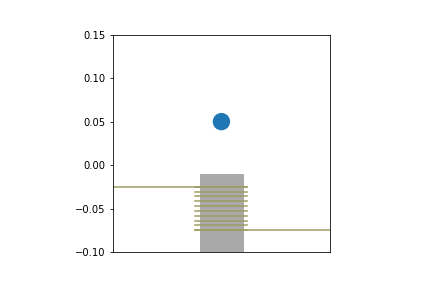
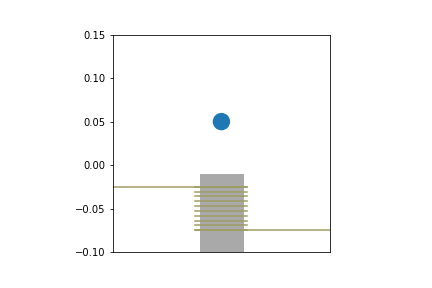
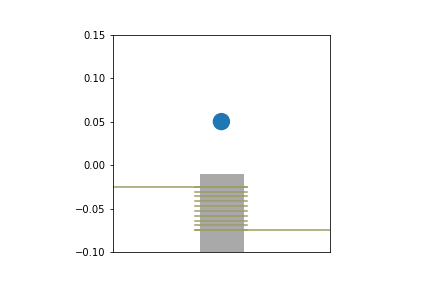
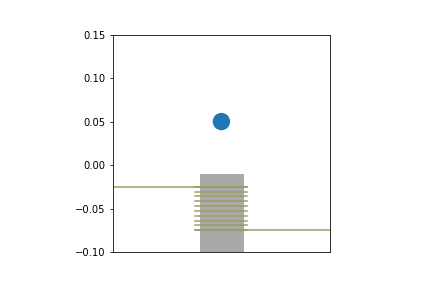
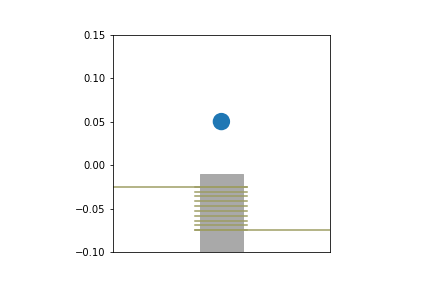
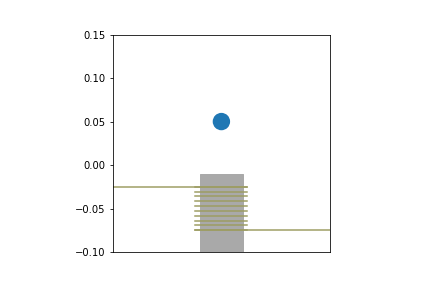
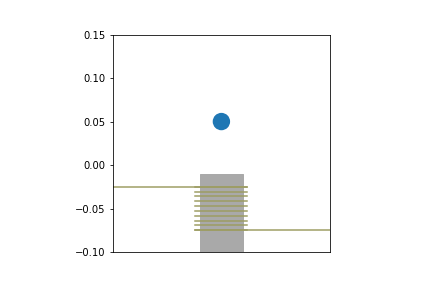
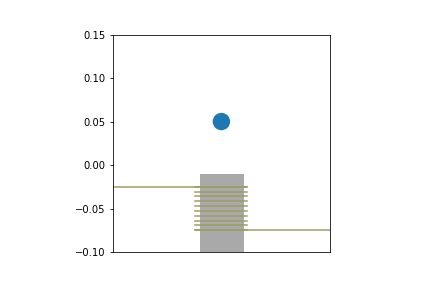
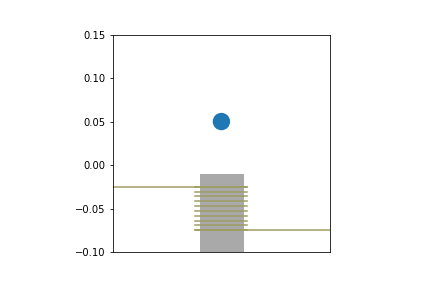
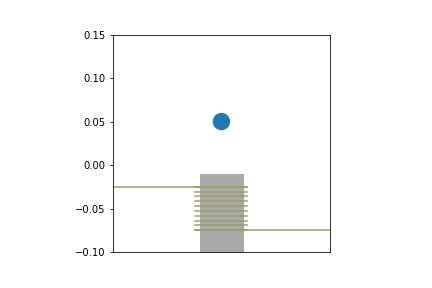
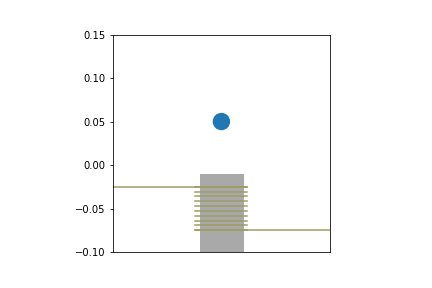
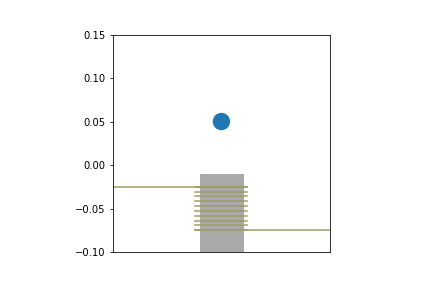
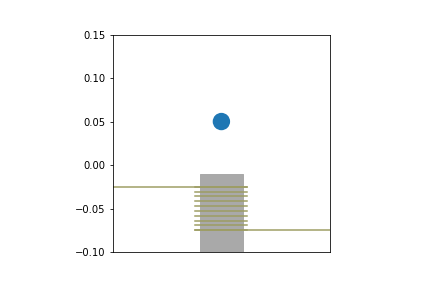
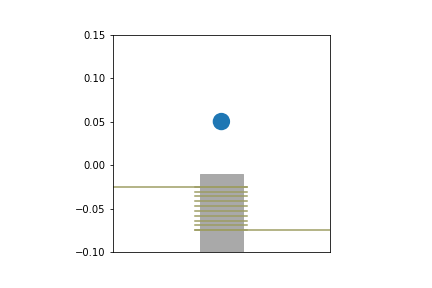
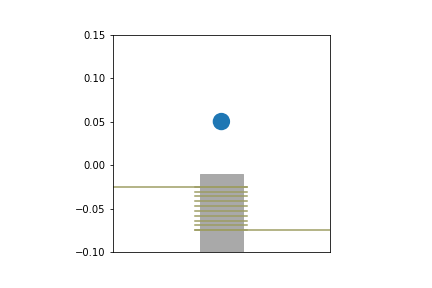
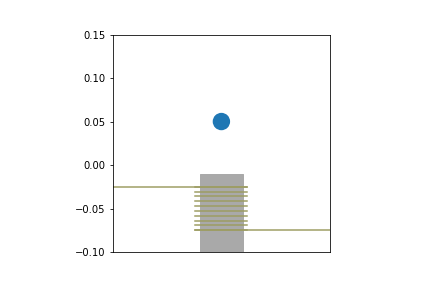
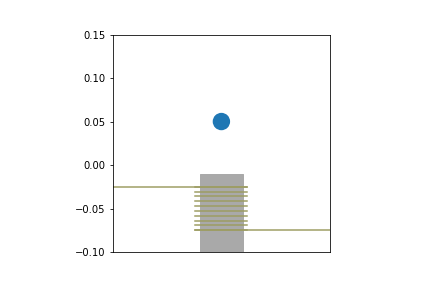
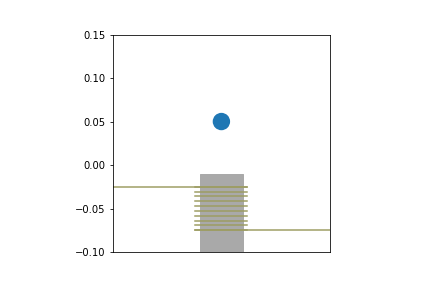
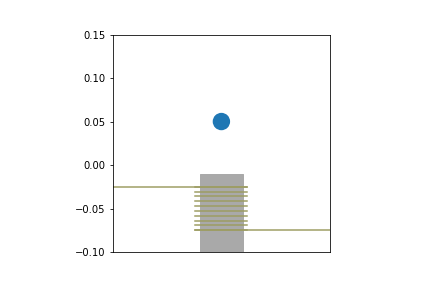
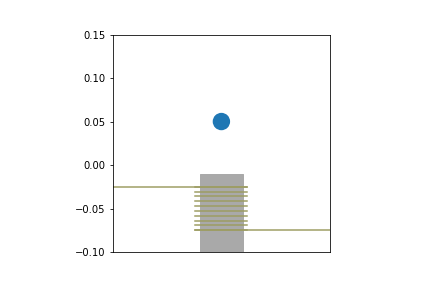
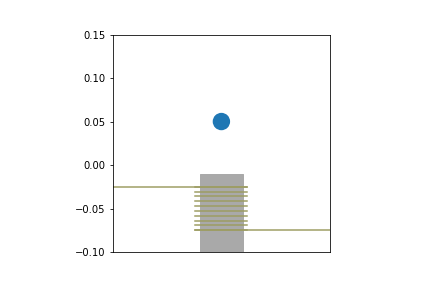
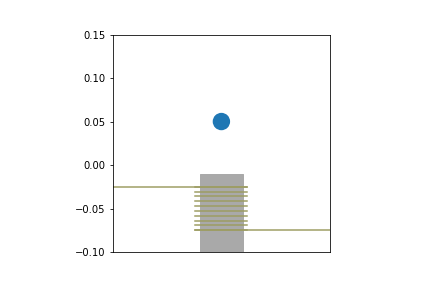
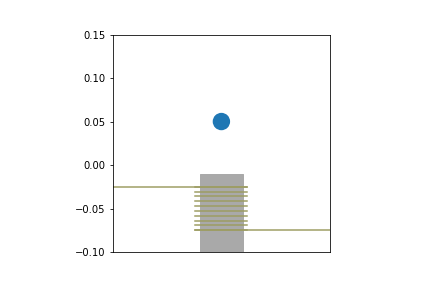
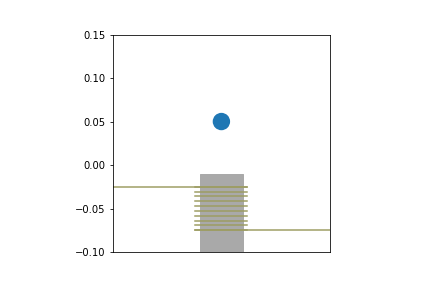
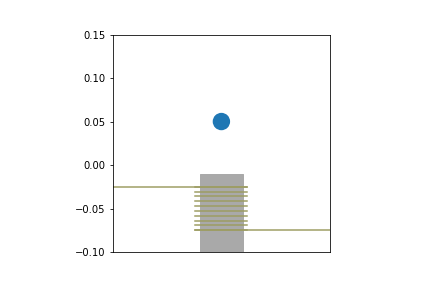
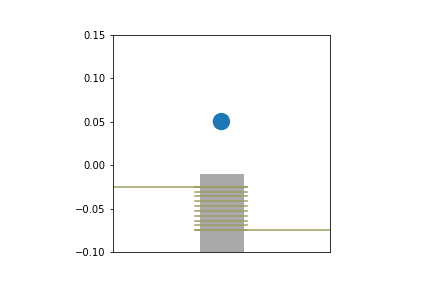
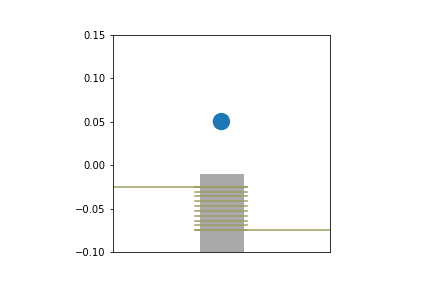
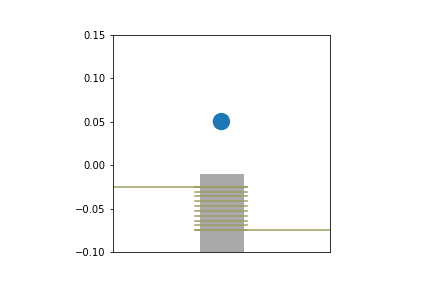
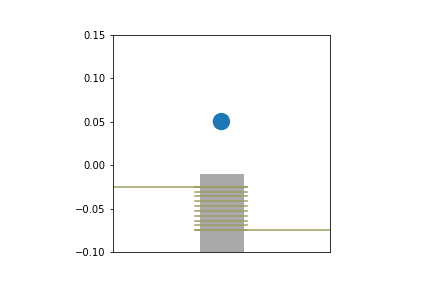
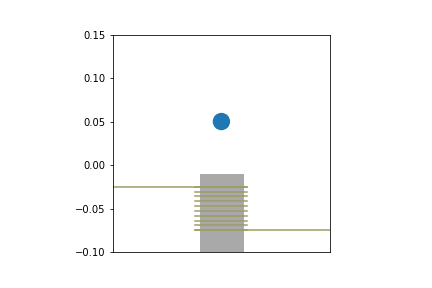
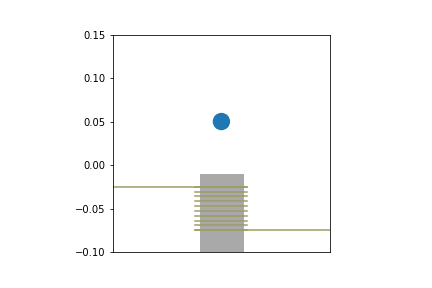
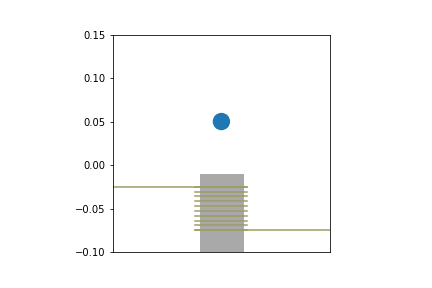
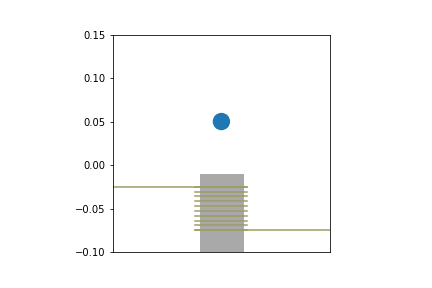
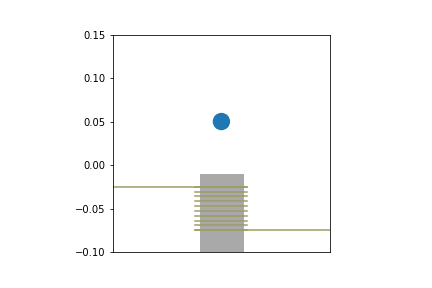
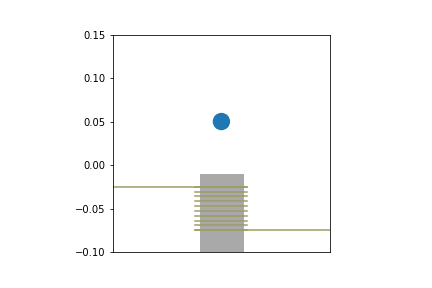
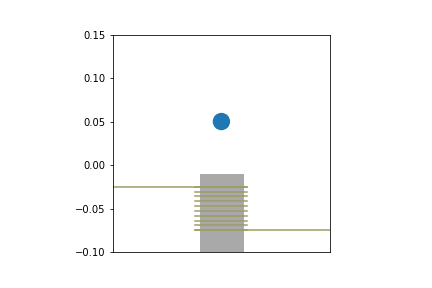
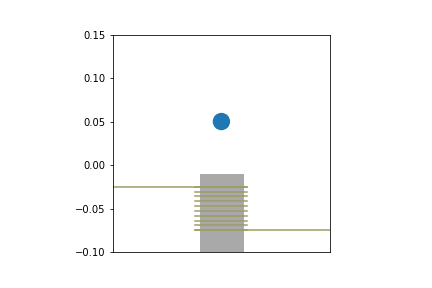
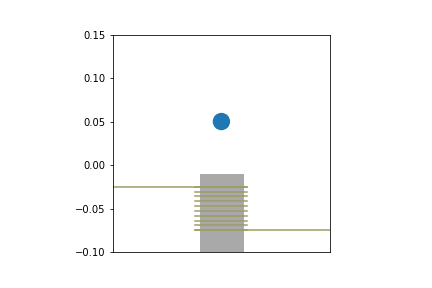
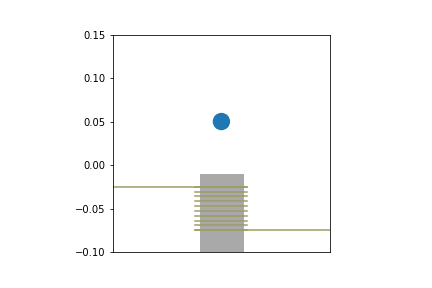
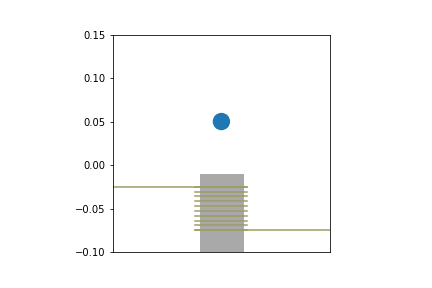
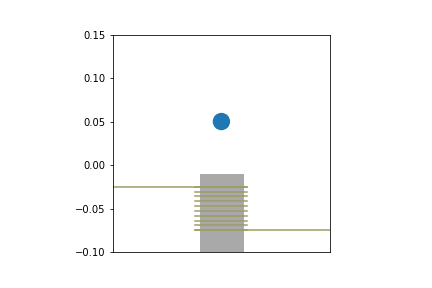
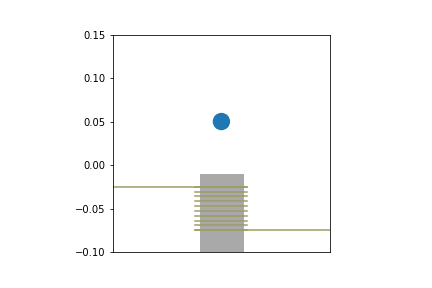
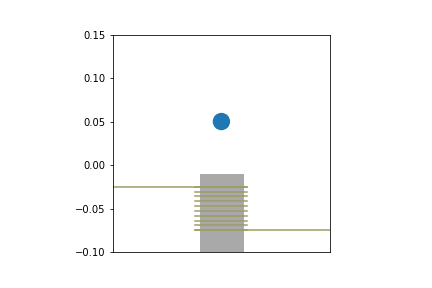
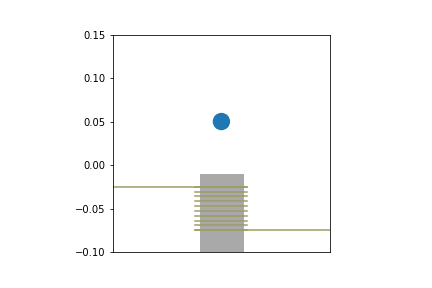
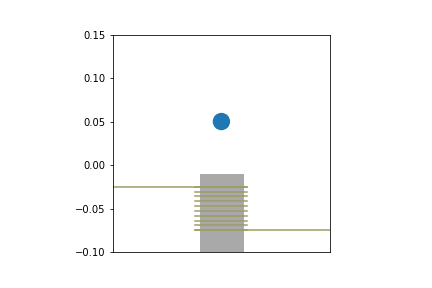
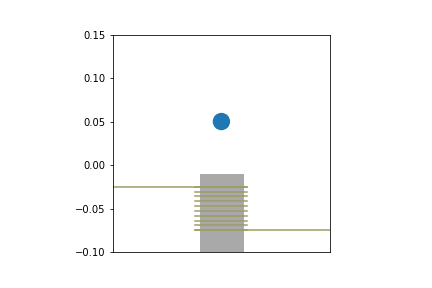
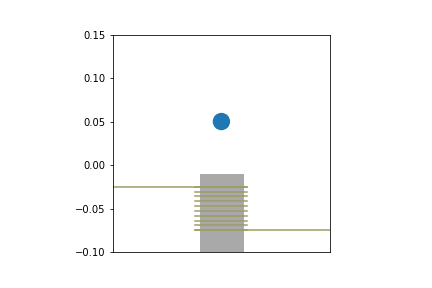
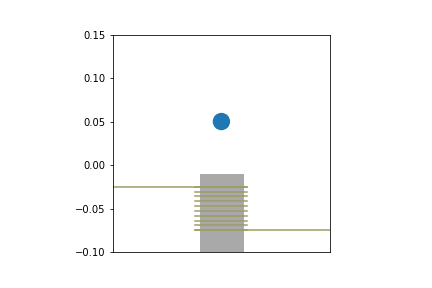
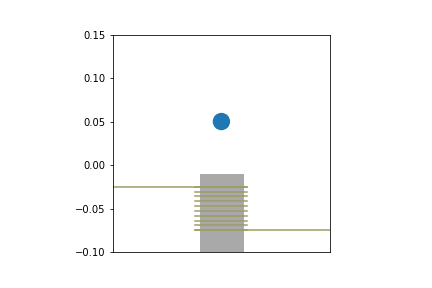
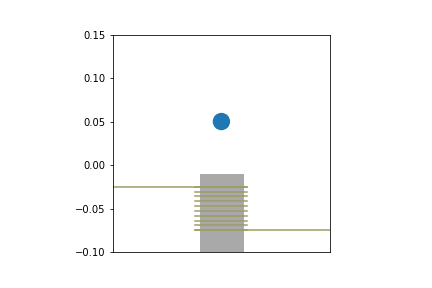
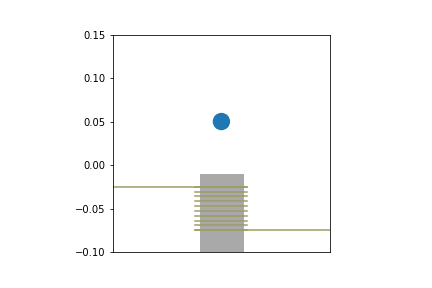
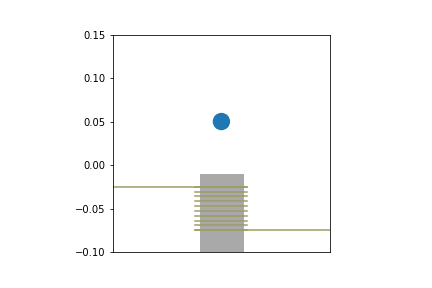
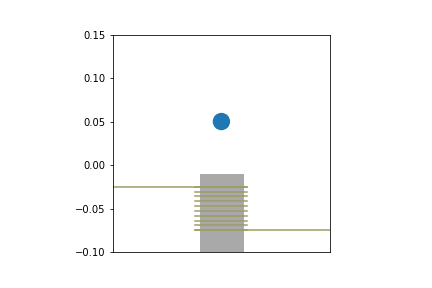
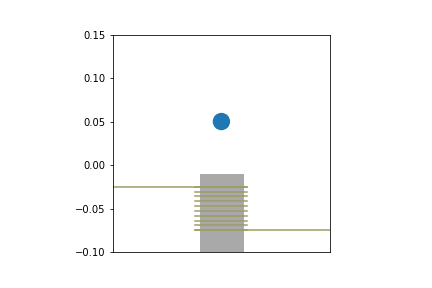
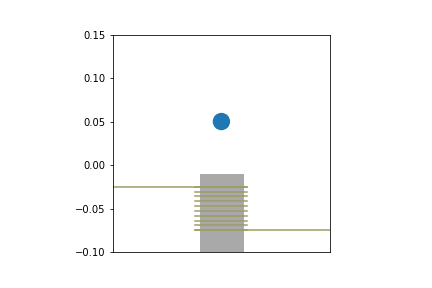
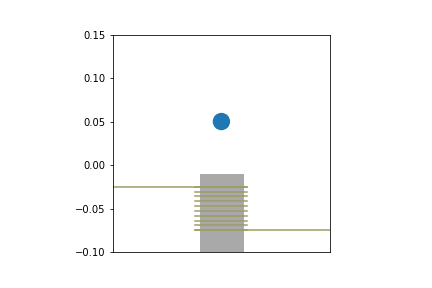
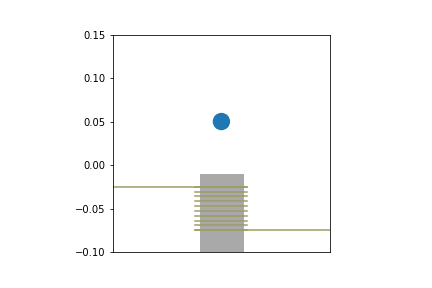
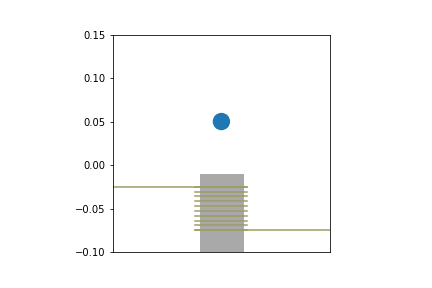
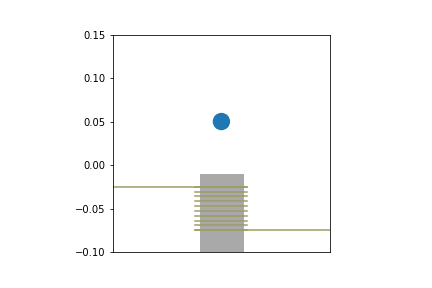
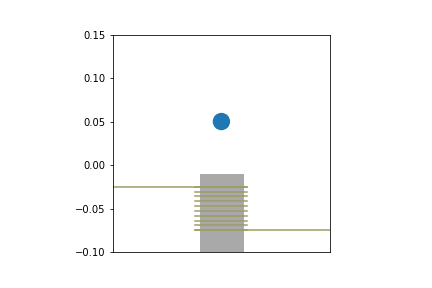
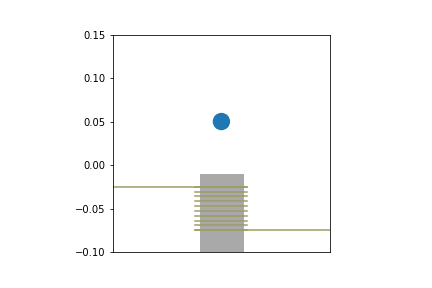
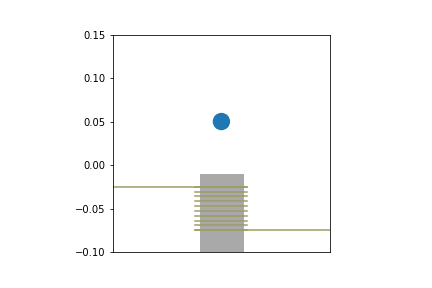
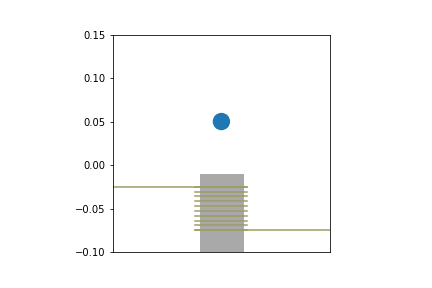
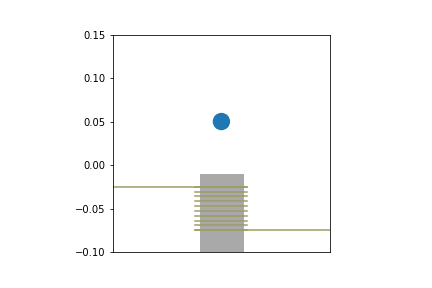
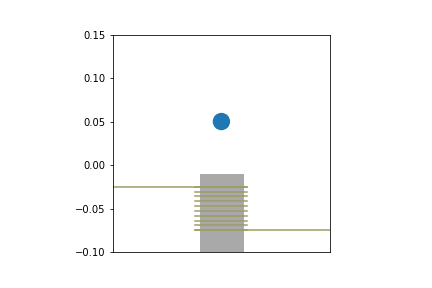
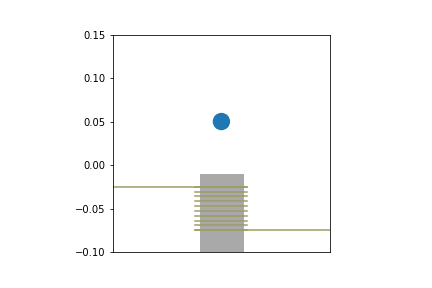
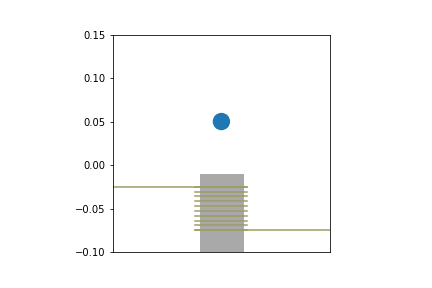
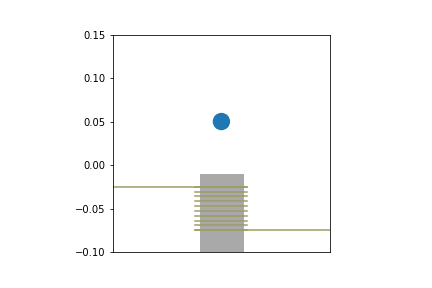
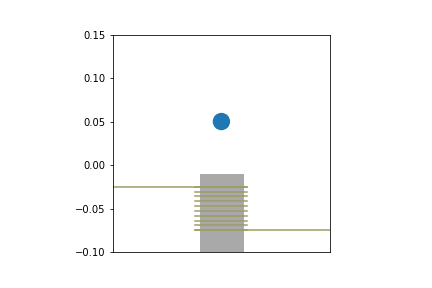
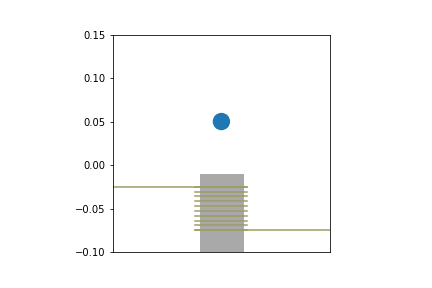
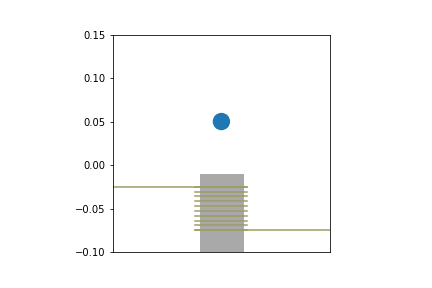
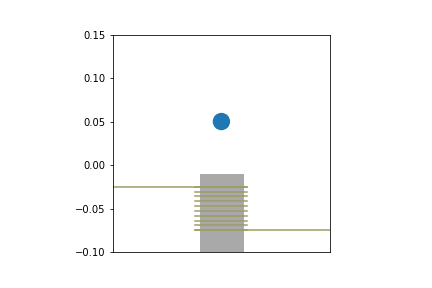

In [10]:
def anim():
    
    # This function is only here so that all the variables below are local to it and
    # we don't overwrite them as defined above.
    
    # Position and current
    x = X[:,0][0]
    i = X[:,2][0]
    
    # Max and min current, for colors
    cmax = max(X[:,2])
    cmin = min(X[:,2])

    # Make the plot
    fig,ax = plt.subplots(1)
    
    # Render the magnet core, ball, and coils
    mag = patches.Rectangle((-0.025,-0.1), 0.05, 0.1-0.01, color="darkgrey")
    ball = patches.Circle((1,x), 0.01)
    coils = ax.plot([-0.125,0.03], [-0.025, -0.025], [-0.03,0.125], [-0.075, -0.075], color='orange')
    for c in np.linspace(-0.025, -0.075,10):
        coils += ax.plot([-0.03,0.03], [c, c], color='orange')  

    # Add the parts to the plot
    ax.add_patch(ball)
    ax.add_patch(mag)
    
    # Make it look nice
    ax.set_xlim(-.125,.125)
    ax.set_ylim(-.1,.15)
    ax.set_xticks([])
    ax.set_aspect(1)

    # Make a frame for each element of the simulation output X
    num_frames = len(X)

    # Define a function that will be called for each frame. It modifies the 
    # position of the ball and the color of the coil.
    def animate(f):
        x = X[:,0][f]
        ball.set_center((0,x))
        c = ( X[:,2][f] - cmin ) / ( cmax - cmin )
        for coil in coils:
            coil.set_color((c,c,1-c))

    # Build the animation
    anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=20)
    return display_animation(anim, default_mode='loop')
    
anim()